In [151]:
from bs4 import BeautifulSoup
%matplotlib inline
import requests
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab as pl

sns.set_context('notebook')
"""
Example usage:
>>> from data_mining import *
>>> mine_data('2009', 'B1', 'Spring')
...


Will output a global data frame indexed by sciper
The data frame is indexed by the the year, semester and sciper
"""

years = {
	'2007': '978181',
	'2008': '978187',
	'2009': '978195',
	'2010': '39486325',
	'2011': '123455150',
	'2012': '123456101',
	'2013': '213637754',
	'2014': '213637922',
	'2015': '213638028',
	'2016': '355925344'
}

semesters = {
	'B1': '249108',
    'B5': '942120',
	'B6': '942175',
	'M1': '2230106',
    'M2': '942192',
	'M3': '2230128',
	'PMAut': '249127',
	'PMSpr': '3781783'
}

indexes =  []

def get_url(year, semester):
    """Get the url corresponding to a given year and semester"""
    y, sem = years[year], semesters[semester]
    return 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD='+ y +'&ww_x_PERIODE_PEDAGO=' + sem + '&ww_x_HIVERETE=null'

def request(year, semester):
    """return the http request corresponding to a given year and semester"""
    url = get_url(year, semester)
    return requests.get(url, verify=False)

def get_soup(year, semester):
    """return the data soup (BeautifulSoup) corresponding to a given year and semester"""
    r = request(year, semester)
    data = r.text
    return BeautifulSoup(data,"lxml")


def get_table(soup, year, semester):
    """Transform the data soup into a dict containing the data frame
    Each dict contains the section, the year, and the dataframe containing all the corresponding data
    The dataframe contains all the columns returned by the html page + the index corresponding to "indexes"
    """
    global indexes
    table = soup.html.body.table ##get to the table
    list_df  = [] ##init list of data frame
    tc = table.children ##every rows of the table
    first_row = next(tc, None)
    attrs = first_row.text.split(',') ##extract the attributes from the header row
    #section = attrs[0]
    #year = attrs[1]
    nb_student = int(attrs[2].split("(")[1].split(" ")[0])
    if nb_student != 0: ##next row should contain columns info (except if there is no student)
        next_row = next(tc, None) ##directly iterate our iterator the next row
        columns = list(map(lambda l: l.text, next_row.children)) ##transform the children into a list of the inner text of each children
        df = pd.DataFrame(columns=columns) ##create the data frame with the columns from this list

        for c in tc:
            t = list(map(lambda l: l.text, c.children))[:-1] ##transform the children into a list of the inner text of each children (corresponding here to each column)
            df.loc[df.shape[0]] = t ##append the data to the last dataframe created

        sciper_c = columns[-1]
        df = df.set_index([sciper_c, 'Nom Prénom'])
        df[semester+'_year'] = year 
    
        return df
    return pd.DataFrame()

def mine_data(year, semester):
    soup = get_soup(year, semester) ##get the soup
    return get_table(soup, year, semester) ##process the soup


In [8]:
df_bachelor =  mine_data('2007', 'B1')
df_bachelor['B5_year'] = float('NaN')
df_bachelor['B6_year'] = float('NaN') # Because nan can only be stored in floating points


for year in range(2007, 2017):
    df_b1 = mine_data(str(year), 'B1')
    #override only if B1 entry is not in the dataframe yet
    df_bachelor = df_bachelor.combine_first(df_b1)
    
    #override the date when newer semester found
    df_b6 = mine_data(str(year), 'B6')
    df_b5 = mine_data(str(year), 'B5')
    df_bachelor.update(df_b6)
    df_bachelor.update(df_b5)

In [9]:
df_bachelor.head(10)
df_bachelor.tail(10)

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
275273,Servat Jean-Marc Patrick,2016,NaN,NaN,Monsieur,,,,,,,Présent,
275313,Dumoulin Paul Milan,2016,NaN,NaN,Monsieur,,,,,,,Présent,
275383,Cochard Victor Angel,2016,NaN,NaN,Monsieur,,,,,,,Présent,
275553,Hu Julien,2016,NaN,NaN,Monsieur,,,,,,,Présent,
275608,Boujo Max,2016,NaN,NaN,Monsieur,,,,,,,Présent,
276016,Wilders Eric Bruno John,2016,NaN,NaN,Monsieur,,,,,,,Présent,
276323,Zeller Corentin Luc Claude,2016,NaN,NaN,Monsieur,,,,,,,Présent,
276507,Thierry D'Argenlieu Nicolas Alain Alexandre Marie,2016,NaN,NaN,Monsieur,,,,,,,Présent,
276937,Chappuis Sébastien Max Roland,2016,NaN,NaN,Monsieur,,,,,,,Présent,


Now we keep the rows which have a value in B1 and B6

In [10]:
df_bachelor = df_bachelor.dropna(subset=['B1_year', 'B6_year'])
df_bachelor.head(10)

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2010,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral
169569,Arévalo Christian,2007,2009,2009,Monsieur,,,,,,,Présent,
169731,Knecht Mathieu,2007,2010,2010,Monsieur,,,,,,,Congé,
169795,Scheiben Pascal,2007,2011,2010,Monsieur,,,,,,,Présent,
171195,Richter Arnaud,2007,2009,2009,Monsieur,,,,,,,Présent,
171619,Buchschacher Nicolas,2007,2009,2009,Monsieur,,,,,,,Présent,
174905,Aubelle Flavien,2007,2011,2011,Monsieur,,,,,,,Présent,
175190,Hanser Valérian,2007,2010,2009,Monsieur,,,,,,,Présent,
175280,Uberti Quentin,2007,2010,2010,Monsieur,,,,,,,Présent,


Bachelor 6 is actually in the spring semester so one year after

In [11]:
df_bachelor[['B6_year']] = df_bachelor[['B6_year']].apply(pd.to_numeric)
df_bachelor['B6_year'] = df_bachelor['B6_year'] + 1

In [12]:
df_bachelor.head(10)

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2011,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral
169569,Arévalo Christian,2007,2009,2010,Monsieur,,,,,,,Présent,
169731,Knecht Mathieu,2007,2010,2011,Monsieur,,,,,,,Congé,
169795,Scheiben Pascal,2007,2011,2011,Monsieur,,,,,,,Présent,
171195,Richter Arnaud,2007,2009,2010,Monsieur,,,,,,,Présent,
171619,Buchschacher Nicolas,2007,2009,2010,Monsieur,,,,,,,Présent,
174905,Aubelle Flavien,2007,2011,2012,Monsieur,,,,,,,Présent,
175190,Hanser Valérian,2007,2010,2010,Monsieur,,,,,,,Présent,
175280,Uberti Quentin,2007,2010,2011,Monsieur,,,,,,,Présent,


In [13]:
def compute_time(df):
    #if the student finishes in the fifth semester, it has done six more months 
    if float(df['B5_year']) >= float(df['B6_year']):
        end = float(df['B5_year']) + 0.5
    #otherwise he finishes in the summer
    else:
        end = float(df['B6_year'])
    # We want to compute the total time spent in months
    # 1st semester is sep-jan, and 2nd feb-jul so count only 5 months to complete 1st.
    # hurray for nitpicking!
    time = (end - float(df['B1_year'])) * 12 - 1 
    return time

In [14]:
df_bachelor['bachelor_months'] = df_bachelor.apply(compute_time, axis=1)

In [15]:
df_bachelor.head(10)

,,B1_year,B5_year,B6_year,Civilité,Ecole Echange,Filière opt.,Mineur,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,bachelor_months
No Sciper,Nom Prénom,,,,,,,,,,,,,
147008,Good Xavier,2008,2010,2011,Monsieur,Carnegie Mellon University Pittsburgh,,,,,,Congé,Bilatéral,35.0
169569,Arévalo Christian,2007,2009,2010,Monsieur,,,,,,,Présent,,35.0
169731,Knecht Mathieu,2007,2010,2011,Monsieur,,,,,,,Congé,,47.0
169795,Scheiben Pascal,2007,2011,2011,Monsieur,,,,,,,Présent,,53.0
171195,Richter Arnaud,2007,2009,2010,Monsieur,,,,,,,Présent,,35.0
171619,Buchschacher Nicolas,2007,2009,2010,Monsieur,,,,,,,Présent,,35.0
174905,Aubelle Flavien,2007,2011,2012,Monsieur,,,,,,,Présent,,59.0
175190,Hanser Valérian,2007,2010,2010,Monsieur,,,,,,,Présent,,41.0
175280,Uberti Quentin,2007,2010,2011,Monsieur,,,,,,,Présent,,47.0


We simply need to group by `Civilité` to get the average time per gender

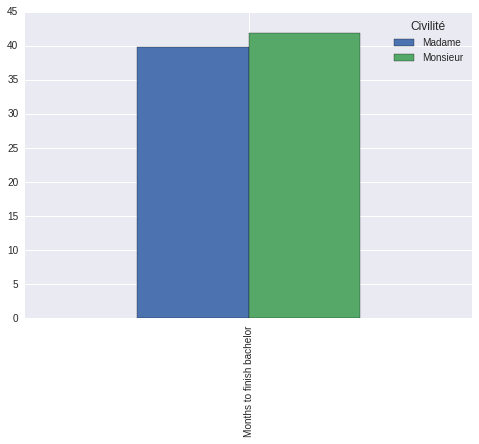

In [16]:
df_bachelor["Civilité"].astype('category')
sex_grouped = df_bachelor.groupby('Civilité')['bachelor_months']
b_months = sex_grouped.apply(np.average)
b_months.to_frame(name='Months to finish bachelor').unstack().unstack().plot.bar()

In [90]:
sex_grouped.head()

No Sciper  Nom Prénom            
147008     Good Xavier               35.0
169569     Arévalo Christian         35.0
169731     Knecht Mathieu            47.0
169795     Scheiben Pascal           53.0
171195     Richter Arnaud            35.0
178706     Falbriard Stéphanie       35.0
179703     Salvisberg Véra           35.0
179988     Portmann Joëlle           35.0
181419     Triponez Elodie Nilane    35.0
184373     Sisto Maria               53.0
Name: bachelor_months, dtype: float64

## Statistical significance
In order to evaluate the statistical significance of the difference in average between the male and female students, we first examine the data as a whole, with regard to the number of months spent to get one's bachelor degree.

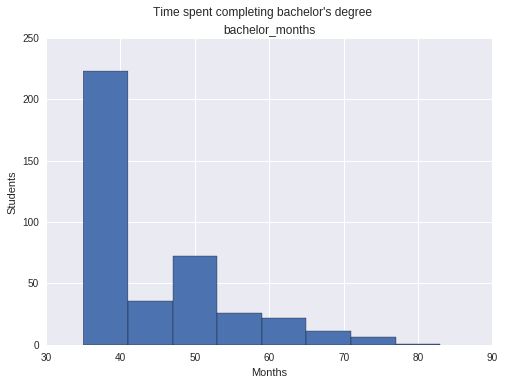

In [126]:
b_months_min = df_bachelor.bachelor_months.min().astype(int)
b_months_max = df_bachelor.bachelor_months.max().astype(int)
df_bachelor.hist(column='bachelor_months', bins=range(b_months_min, b_months_max+1, 6))
pl.suptitle("Time spent completing bachelor's degree")
pl.xlabel("Months")
pl.ylabel("Students")

As can be expected, most students complete the bachelor's in 36 months (the mandatory 3 years). A fair amount will need 6 or 12 months more. If we now look at the structure of the data by gender, we can see that it holds roughly the same shape in both cases.

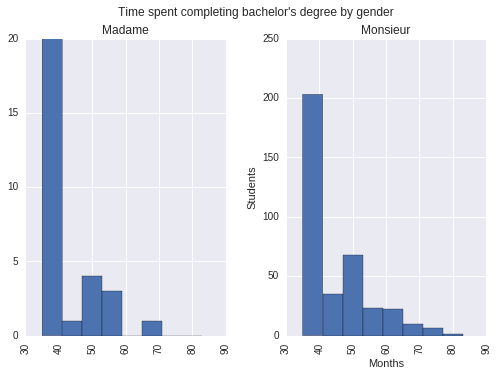

In [127]:
df_bachelor.hist(column='bachelor_months', by=df_bachelor['Civilité'], bins=range(b_months_min, b_months_max+1, 6))
pl.suptitle("Time spent completing bachelor's degree by gender")
pl.xlabel("Months")
pl.ylabel("Students")

### Test 1

Since we are observing a dependent variable (i.e. the n° of months to complete a bachelor's degree) in two population samples determined by an independent variable (i.e. the gender of the person), we use an **independent two sample t-test**, as provided in `scipy`'s `ttest_ind` function.

In [124]:
values_per_gender = [gender_value for gender_name, gender_value in sex_grouped]
stat, pval = stats.ttest_ind(*values_per_gender)

So in this case, we're working with the null hypothesis $H_0$ that the mean in months spent for a bachelor's degree of the two populations, male and female students in computer science, is equal. 

With our two samples, we get the following p-value:

In [125]:
pval

0.2409527870885366

This is above any reasonable $\alpha$ (usually around 0.025 for two-tailed tests). So the test indicates to accept $H_0$, i.e. that this difference in mean is *not statistically significant*.

However, the assumption behind using a t-test is that the sample means follow a normal distribution. By the Central Limit Theorem, we know that this is the case. And it stands to reason, since the mean of months needed to complete a bachelor's degree will always be slightly above 35, the majority of individuals will finish it in three years, but less isn't possible.

### Test 2

As an additional test to avoid arbitrary inaccuracies of the t-test we used, we can try the K-S test on our two sample data distributions. This is a non-parametric test, and basically computes the max distance between the cumulative distribution functions of the two distributions. 

In [168]:
stat, pval = stats.ks_2samp(*values_per_gender)
pval

0.65225950107177355

Once again, the result of the test indicates that we should accept $H_0$. So we can state that the difference in the mean value between the number of months needed by women and men is not statistically significant.

# Question 2 

Get the data

In [22]:
df_master =  mine_data('2007', 'M1')
df_master['M1_year'] = float('NaN')
df_master['M2_year'] = float('NaN')
df_master['M3_year'] = float('NaN')
df_master['PMAut_year'] = float('NaN')
df_master['PMSpr_year'] = float('NaN')
df_master['Spécialisation'] = str('NaN')

for year in range(2007, 2017):
    df_m1 = mine_data(str(year), 'M1')
    #override only if B1 is not in the dataframe yet
    df_master = df_master.combine_first(df_m1)
    
    #override the date when older semester found
    df_m2 = mine_data(str(year), 'M2')
    df_m3 = mine_data(str(year), 'M3')
    df_p1 = mine_data(str(year), 'PMAut')
    df_p2 = mine_data(str(year), 'PMSpr')
    df_master.update(df_m2)
    df_master.update(df_m3)
    df_master.update(df_p1)
    df_master.update(df_p2)

In [128]:
df_master.head(10)

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,,,
138088,Droz-dit-Busset Arnault,Monsieur,,,2007.0,NaN,NaN,,,,NaN,NaN,NaN,Présent,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008,,,,NaN,NaN,,Présent,
146742,Marx Clément,Monsieur,,,2008.0,2009,2012,,,,2010,2010,"Signals, Images and Interfaces",Présent,
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
147008,Good Xavier,Monsieur,,,2011.0,2012,2012,,,,NaN,NaN,,Présent,
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009,,,,NaN,NaN,Internet computing,Présent,
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
153762,Conus Johann,Monsieur,,,2008.0,2009,2009,,,,NaN,NaN,,Présent,


Drop the ones without M1 and M2 entries

In [24]:
df_m = df_master.dropna(subset=['M1_year', 'M2_year'])

In [129]:
df_m.head(10)

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange,master_years
No Sciper,Nom Prénom,,,,,,,,,,,,,,,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,,Présent,,1.5
146742,Marx Clément,Monsieur,,,2008.0,2009,2012.0,,,,2010.0,2010.0,"Signals, Images and Interfaces",Présent,,2.5
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,,1.0
147008,Good Xavier,Monsieur,,,2011.0,2012,2012.0,,,,NaN,NaN,,Présent,,1.5
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008.0,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,,1.5
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,,1.0
153762,Conus Johann,Monsieur,,,2008.0,2009,2009.0,,,,NaN,NaN,,Présent,,1.5
154080,Fomene Tierry Alain,Monsieur,,,2007.0,2008,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5


To compute stay:
-if PMAut_year or PMSpr_year is not empty, then this is the last value - M1_year
-if M3_year 

# TODO delete rows with Mineur and not M3_year

In [26]:
#df_m[((df_m.Mineur != '') and (df_m.M3_year > 0)) | (df_m.Mineur == '')]

In [27]:
df_m[['M1_year','M2_year','M3_year','PMAut_year','PMSpr_year']] = df_m[['M1_year','M2_year','M3_year','PMAut_year','PMSpr_year']].apply(pd.to_numeric)

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [28]:
df_m

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange
No Sciper,Nom Prénom,,,,,,,,,,,,,,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,,Présent,
146742,Marx Clément,Monsieur,,,2008.0,2009,2012.0,,,,2010.0,2010.0,"Signals, Images and Interfaces",Présent,
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
147008,Good Xavier,Monsieur,,,2011.0,2012,2012.0,,,,NaN,NaN,,Présent,
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008.0,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009.0,,,,NaN,NaN,Internet computing,Présent,
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,
153762,Conus Johann,Monsieur,,,2008.0,2009,2009.0,,,,NaN,NaN,,Présent,
154080,Fomene Tierry Alain,Monsieur,,,2007.0,2008,2009.0,,,,NaN,NaN,Internet computing,Présent,


In [29]:
def compute_time_master(df):
    #if the student has done a master project 
    if (not pd.isnull(df['PMAut_year'])):
        end = float(df['PMAut_year']) + 0.5
    elif (not pd.isnull(df['PMSpr_year'])):
        end = float(df['PMSpr_year']) + 1
    elif (not pd.isnull(df['M3_year'])):
        end = float(df['M3_year']) + 0.5
    else:
        end = float(df['M2_year']) + 1
    time = float(end) - float(df['M1_year'])
    return time

In [30]:
df_m['master_years'] = df_m.apply(compute_time_master, axis=1)

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [31]:
df_m

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange,master_years
No Sciper,Nom Prénom,,,,,,,,,,,,,,,
146330,Cardinaux Damien,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,,Présent,,1.5
146742,Marx Clément,Monsieur,,,2008.0,2009,2012.0,,,,2010.0,2010.0,"Signals, Images and Interfaces",Présent,,2.5
146929,Junod Antoine,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,,1.0
147008,Good Xavier,Monsieur,,,2011.0,2012,2012.0,,,,NaN,NaN,,Présent,,1.5
152232,Anagnostaras David,Monsieur,,,2007.0,2007,2008.0,"Mineur en Management, technologie et entrepren...",,,NaN,NaN,,Présent,,1.5
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5
153746,Cassina Ilya,Monsieur,,,2007.0,2007,NaN,,,,NaN,NaN,,Présent,,1.0
153762,Conus Johann,Monsieur,,,2008.0,2009,2009.0,,,,NaN,NaN,,Présent,,1.5
154080,Fomene Tierry Alain,Monsieur,,,2007.0,2008,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5


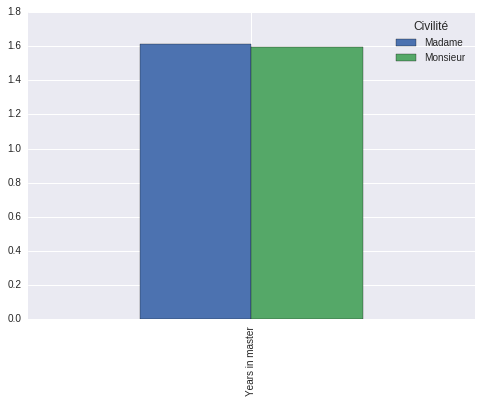

In [32]:
df_m["Civilité"].astype('category')
sex_grouped_master = df_m.groupby('Civilité')['master_years']
m_years = sex_grouped_master.apply(np.average)
m_years.to_frame(name='Years in master').unstack().unstack().plot.bar()

Now we look at the Spécialisation

In [33]:
df_spec = df_m[df_m['Spécialisation'] != '']

In [34]:
df_spec

,,Civilité,Ecole Echange,Filière opt.,M1_year,M2_year,M3_year,Mineur,Orientation Bachelor,Orientation Master,PMAut_year,PMSpr_year,Spécialisation,Statut,Type Echange,master_years
No Sciper,Nom Prénom,,,,,,,,,,,,,,,
146742,Marx Clément,Monsieur,,,2008.0,2009,2012.0,,,,2010.0,2010.0,"Signals, Images and Interfaces",Présent,,2.5
153066,Aeberhard François-Xavier,Monsieur,,,2007.0,2009,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5
154080,Fomene Tierry Alain,Monsieur,,,2007.0,2008,2009.0,,,,NaN,NaN,Internet computing,Présent,,2.5
154573,Benabdallah Zeineb,Madame,,,2007.0,2008,2009.0,,,,NaN,2009.0,Biocomputing,Présent,,3.0
159998,Jesse Julia,Madame,,,2008.0,2008,2009.0,,,,NaN,NaN,"Signals, Images and Interfaces",Présent,,1.5
160254,Kohler Johann,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,Internet computing,Présent,,1.5
160718,Copponnex Hadrien,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,Foundations of Software,Présent,,1.5
160991,Schintgen Joël,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,Internet computing,Présent,,1.5
161357,Gfeller Sebastian,Monsieur,,,2007.0,2007,2008.0,,,,NaN,NaN,Foundations of Software,Présent,,1.5


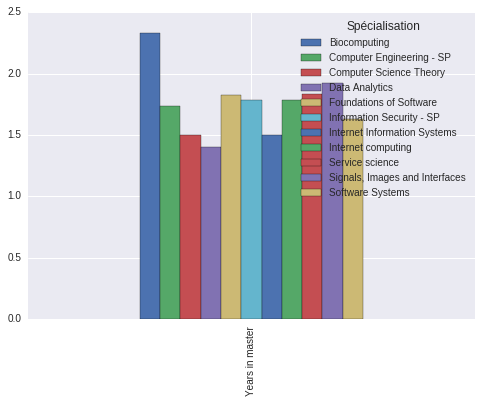

In [35]:
df_spec["Spécialisation"].astype('category')
spec_grouped_master = df_spec.groupby('Spécialisation')['master_years']
m_spec = spec_grouped_master.apply(np.average)
m_spec.to_frame(name='Years in master').unstack().unstack().plot.bar()
